# Importing libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.express as px



# Reading Data

In [ ]:
tw=pd.read_csv('/content/x_df.csv') 
tw.head(1)

,Unnamed: 0,date,anger_val,anti_val,joy_val,fear_val,sad_val,sur_val,trust_val,dis_val
0,0,2022-02-02 00:00:00,0.052839,0.096248,0.065374,0.054623,0.034984,0.03713,0.100005,0.013804


In [ ]:
del tw['Unnamed: 0']
tw.head(1)

,date,anger_val,anti_val,joy_val,fear_val,sad_val,sur_val,trust_val,dis_val
0,2022-02-02 00:00:00,0.052839,0.096248,0.065374,0.054623,0.034984,0.03713,0.100005,0.013804


In [ ]:
bt=pd.read_csv('/content/y_df.csv') 
bt.head(1)

,Unnamed: 0,date,close_price
0,0,2022-02-02 00:00:00,38579.04


In [ ]:
del bt['Unnamed: 0']
bt.head(1)

,date,close_price
0,2022-02-02 00:00:00,38579.04


In [ ]:
merged_data = tw.merge(bt,on=["date"])
merged_data.head(2)

,date,anger_val,anti_val,joy_val,fear_val,sad_val,sur_val,trust_val,dis_val,close_price
0,2022-02-02 00:00:00,0.052839,0.096248,0.065374,0.054623,0.034984,0.037130,0.100005,0.013804,38579.04
1,2022-02-02 01:00:00,0.059117,0.097947,0.061584,0.049436,0.037325,0.035965,0.099951,0.020480,38475.38


# Multifeature Sentiment Analysis

In [ ]:
df1 = merged_data
df1.head()

,date,anger_val,anti_val,joy_val,fear_val,sad_val,sur_val,trust_val,dis_val,close_price
0,2022-02-02 00:00:00,0.052839,0.096248,0.065374,0.054623,0.034984,0.037130,0.100005,0.013804,38579.04
1,2022-02-02 01:00:00,0.059117,0.097947,0.061584,0.049436,0.037325,0.035965,0.099951,0.020480,38475.38
2,2022-02-02 02:00:00,0.068473,0.103367,0.070476,0.051053,0.034347,0.043523,0.115820,0.024383,38656.26
3,2022-02-02 03:00:00,0.053878,0.114689,0.076525,0.056947,0.047313,0.049092,0.117352,0.015350,38589.96
4,2022-02-02 04:00:00,0.049760,0.120001,0.097081,0.052094,0.041772,0.051421,0.123106,0.012648,38462.58


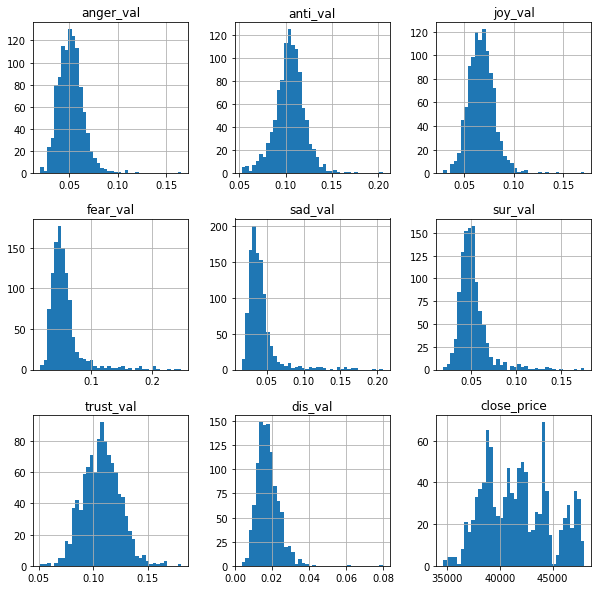

In [ ]:
df1.hist(figsize=(10, 10), bins = 40);

In [ ]:
df1.set_index('date',inplace=True)

In [ ]:
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.head()

,close_price,anger_val,anti_val,joy_val,fear_val,sad_val,sur_val,trust_val,dis_val
date,,,,,,,,,
2022-02-02 00:00:00,38579.04,0.052839,0.096248,0.065374,0.054623,0.034984,0.037130,0.100005,0.013804
2022-02-02 01:00:00,38475.38,0.059117,0.097947,0.061584,0.049436,0.037325,0.035965,0.099951,0.020480
2022-02-02 02:00:00,38656.26,0.068473,0.103367,0.070476,0.051053,0.034347,0.043523,0.115820,0.024383
2022-02-02 03:00:00,38589.96,0.053878,0.114689,0.076525,0.056947,0.047313,0.049092,0.117352,0.015350
2022-02-02 04:00:00,38462.58,0.049760,0.120001,0.097081,0.052094,0.041772,0.051421,0.123106,0.012648


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df1.values)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# One Day Lag

In [ ]:
n_hours = 24
n_features = 9
n_obs = n_hours*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var1(t-23),...,var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
24,0.294332,0.226218,0.286508,0.256247,0.161095,0.098625,0.115310,0.376842,0.132628,0.286559,...,0.182691,0.723125,0.217198,0.335721,0.223754,0.154414,0.128657,0.194818,0.339580,0.245474
25,0.286559,0.269399,0.297660,0.229618,0.138442,0.110863,0.107853,0.376430,0.220326,0.300124,...,0.245474,0.704753,0.266345,0.393208,0.304477,0.194778,0.205878,0.151994,0.427532,0.240533
26,0.300124,0.333747,0.333245,0.292100,0.145503,0.095293,0.156221,0.499285,0.271585,0.295151,...,0.240533,0.718809,0.201246,0.381340,0.373053,0.183520,0.129848,0.110202,0.519425,0.218325
27,0.295151,0.233370,0.407573,0.334605,0.171242,0.163084,0.191860,0.511148,0.152932,0.285599,...,0.218325,0.727992,0.203634,0.312528,0.299317,0.134117,0.165359,0.153905,0.452894,0.226710
28,0.285599,0.205045,0.442443,0.479048,0.150049,0.134114,0.206761,0.555697,0.117444,0.282862,...,0.226710,0.722756,0.228976,0.308668,0.359742,0.207662,0.167429,0.156126,0.416753,0.369298


In [ ]:
reframed = reframed.drop(reframed.columns[-8:], axis=1)
reframed.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var1(t-23),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
24,0.294332,0.226218,0.286508,0.256247,0.161095,0.098625,0.115310,0.376842,0.132628,0.286559,...,0.170177,0.199395,0.296274,0.205265,0.145797,0.093101,0.122666,0.307031,0.182691,0.723125
25,0.286559,0.269399,0.297660,0.229618,0.138442,0.110863,0.107853,0.376430,0.220326,0.300124,...,0.723125,0.217198,0.335721,0.223754,0.154414,0.128657,0.194818,0.339580,0.245474,0.704753
26,0.300124,0.333747,0.333245,0.292100,0.145503,0.095293,0.156221,0.499285,0.271585,0.295151,...,0.704753,0.266345,0.393208,0.304477,0.194778,0.205878,0.151994,0.427532,0.240533,0.718809
27,0.295151,0.233370,0.407573,0.334605,0.171242,0.163084,0.191860,0.511148,0.152932,0.285599,...,0.718809,0.201246,0.381340,0.373053,0.183520,0.129848,0.110202,0.519425,0.218325,0.727992
28,0.285599,0.205045,0.442443,0.479048,0.150049,0.134114,0.206761,0.555697,0.117444,0.282862,...,0.727992,0.203634,0.312528,0.299317,0.134117,0.165359,0.153905,0.452894,0.226710,0.722756


In [ ]:
values = reframed.values
n_train_hours = 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(24, 217)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(24, 216) (24,) (1008, 216) (1008,)


In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(24, 24, 9) (24,) (1008, 24, 9) (1008,)


## LSTM Model

In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
6/6 - 6s - loss: 0.0378 - val_loss: 0.0149 - 6s/epoch - 996ms/step
Epoch 2/100
6/6 - 1s - loss: 0.0325 - val_loss: 0.0176 - 1s/epoch - 177ms/step
Epoch 3/100
6/6 - 1s - loss: 0.0308 - val_loss: 0.0205 - 1s/epoch - 233ms/step
Epoch 4/100
6/6 - 1s - loss: 0.0305 - val_loss: 0.0218 - 1s/epoch - 226ms/step
Epoch 5/100
6/6 - 1s - loss: 0.0303 - val_loss: 0.0216 - 1s/epoch - 178ms/step
Epoch 6/100
6/6 - 1s - loss: 0.0300 - val_loss: 0.0206 - 1s/epoch - 228ms/step
Epoch 7/100
6/6 - 1s - loss: 0.0297 - val_loss: 0.0194 - 1s/epoch - 225ms/step
Epoch 8/100
6/6 - 1s - loss: 0.0295 - val_loss: 0.0186 - 1s/epoch - 231ms/step
Epoch 9/100
6/6 - 1s - loss: 0.0293 - val_loss: 0.0180 - 797ms/epoch - 133ms/step
Epoch 10/100
6/6 - 1s - loss: 0.0292 - val_loss: 0.0177 - 549ms/epoch - 92ms/step
Epoch 11/100
6/6 - 1s - loss: 0.0290 - val_loss: 0.0176 - 681ms/epoch - 114ms/step
Epoch 12/100
6/6 - 1s - loss: 0.0288 - val_loss: 0.0176 - 565ms/epoch - 94ms/step
Epoch 13/100
6/6 - 1s - loss: 0.0286 - 

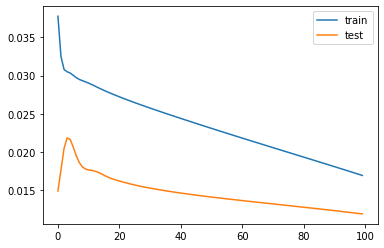

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1451.801


In [ ]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent_1day.csv')

In [ ]:
df1day=pd.read_csv('/content/Predictions_nosent_1day.csv')
df1day.head(5)

,Unnamed: 0,forecast,actual
0,0,38642.933679,37921.227904
1,1,39095.368272,38161.100613
2,2,39275.013295,38733.468408
3,3,39219.769237,38242.118333
4,4,39364.248256,37952.707025


In [ ]:
y=[]
for i in range(len(df1day)):
  x=((abs(df1day['forecast'][i] - df1day['actual'][i] ))  / df1day['actual'][i])*100
  y.append(x)

def Average(lst):
    return sum(lst) / len(lst)

print(Average(y))
Accuracy = 100 - Average(y)
print('The one day Accuracy is .{}'.format((Accuracy)))

1.0740387216120826
The one day Accuracy is .98.92596127838792


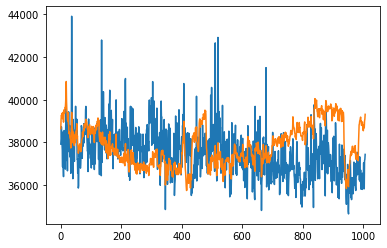

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

# Three Days Lag

In [ ]:
n_hours = 72
n_features = 9
n_obs = n_hours*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
72,0.294332,0.226218,0.286508,0.256247,0.161095,0.098625,0.115310,0.376842,0.132628,0.286559,...,0.278281,0.582640,0.285287,0.349555,0.304638,0.165334,0.105814,0.200034,0.439883,0.286605
73,0.286559,0.269399,0.297660,0.229618,0.138442,0.110863,0.107853,0.376430,0.220326,0.300124,...,0.286605,0.569459,0.358283,0.275703,0.290668,0.209410,0.125294,0.123629,0.331728,0.280943
74,0.300124,0.333747,0.333245,0.292100,0.145503,0.095293,0.156221,0.499285,0.271585,0.295151,...,0.280943,0.568828,0.218606,0.191501,0.171686,0.173953,0.032713,0.043108,0.310697,0.121944
75,0.295151,0.233370,0.407573,0.334605,0.171242,0.163084,0.191860,0.511148,0.152932,0.285599,...,0.121944,0.570609,0.299209,0.300069,0.312169,0.142491,0.051331,0.118587,0.463301,0.190424
76,0.285599,0.205045,0.442443,0.479048,0.150049,0.134114,0.206761,0.555697,0.117444,0.282862,...,0.190424,0.568927,0.310245,0.317335,0.325030,0.175611,0.186147,0.237525,0.372498,0.238268


In [ ]:
reframed = reframed.drop(reframed.columns[-8:], axis=1)
reframed.head()

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
72,0.294332,0.226218,0.286508,0.256247,0.161095,0.098625,0.115310,0.376842,0.132628,0.286559,...,0.837382,0.332953,0.338537,0.333803,0.193549,0.109871,0.154759,0.361110,0.278281,0.582640
73,0.286559,0.269399,0.297660,0.229618,0.138442,0.110863,0.107853,0.376430,0.220326,0.300124,...,0.582640,0.285287,0.349555,0.304638,0.165334,0.105814,0.200034,0.439883,0.286605,0.569459
74,0.300124,0.333747,0.333245,0.292100,0.145503,0.095293,0.156221,0.499285,0.271585,0.295151,...,0.569459,0.358283,0.275703,0.290668,0.209410,0.125294,0.123629,0.331728,0.280943,0.568828
75,0.295151,0.233370,0.407573,0.334605,0.171242,0.163084,0.191860,0.511148,0.152932,0.285599,...,0.568828,0.218606,0.191501,0.171686,0.173953,0.032713,0.043108,0.310697,0.121944,0.570609
76,0.285599,0.205045,0.442443,0.479048,0.150049,0.134114,0.206761,0.555697,0.117444,0.282862,...,0.570609,0.299209,0.300069,0.312169,0.142491,0.051331,0.118587,0.463301,0.190424,0.568927


In [ ]:
values = reframed.values
n_train_hours = 72
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(72, 649)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(72, 72, 9) (72,) (912, 72, 9) (912,)


In [ ]:
input_shape=(train_X.shape[1], train_X.shape[2])
input_shape

(72, 9)

## LSTM Model

In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
18/18 - 5s - loss: 0.5529 - val_loss: 0.2776 - 5s/epoch - 270ms/step
Epoch 2/100
18/18 - 2s - loss: 0.2564 - val_loss: 0.1143 - 2s/epoch - 101ms/step
Epoch 3/100
18/18 - 1s - loss: 0.1094 - val_loss: 0.0384 - 1s/epoch - 76ms/step
Epoch 4/100
18/18 - 1s - loss: 0.0393 - val_loss: 0.0108 - 1s/epoch - 73ms/step
Epoch 5/100
18/18 - 1s - loss: 0.0145 - val_loss: 0.0082 - 1s/epoch - 76ms/step
Epoch 6/100
18/18 - 1s - loss: 0.0108 - val_loss: 0.0098 - 1s/epoch - 72ms/step
Epoch 7/100
18/18 - 1s - loss: 0.0108 - val_loss: 0.0095 - 1s/epoch - 73ms/step
Epoch 8/100
18/18 - 1s - loss: 0.0106 - val_loss: 0.0090 - 1s/epoch - 71ms/step
Epoch 9/100
18/18 - 1s - loss: 0.0104 - val_loss: 0.0088 - 1s/epoch - 66ms/step
Epoch 10/100
18/18 - 1s - loss: 0.0103 - val_loss: 0.0087 - 1s/epoch - 66ms/step
Epoch 11/100
18/18 - 1s - loss: 0.0102 - val_loss: 0.0087 - 1s/epoch - 68ms/step
Epoch 12/100
18/18 - 1s - loss: 0.0101 - val_loss: 0.0086 - 1s/epoch - 65ms/step
Epoch 13/100
18/18 - 1s - loss: 0.0

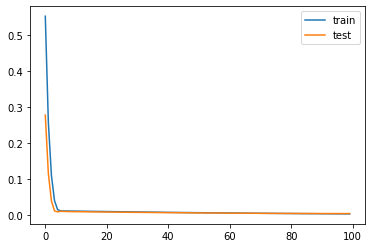

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 775.082


In [ ]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent_3days.csv')

In [ ]:
df3day=pd.read_csv('/content/Predictions_nosent_3days.csv')
df1day.head(5)

,Unnamed: 0,forecast,actual
0,0,37851.661840,38162.764856
1,1,37555.752146,37808.791052
2,2,38024.590467,38069.656152
3,3,37231.079497,37604.305458
4,4,38749.963256,39432.246024


In [ ]:
y=[]
for i in range(len(df3day)):
  x=((abs(df3day['forecast'][i] - df3day['actual'][i] ))  / df3day['actual'][i])*100
  y.append(x)

def Average(lst):
    return sum(lst) / len(lst)

print(Average(y))
Accuracy = 100 - Average(y)
print('The one day Accuracy is .{}'.format((Accuracy)))

1.564754251784082
The one day Accuracy is .98.43524574821592


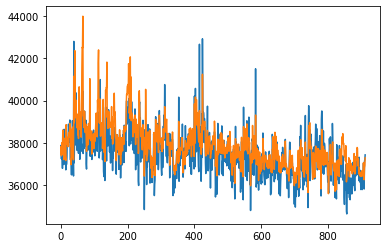

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

# One week Lag

In [ ]:
n_hours = 168
n_features = 9
n_obs = n_hours*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-168),var2(t-168),var3(t-168),var4(t-168),var5(t-168),var6(t-168),var7(t-168),var8(t-168),var9(t-168),var1(t-167),...,var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
168,0.294332,0.226218,0.286508,0.256247,0.161095,0.098625,0.115310,0.376842,0.132628,0.286559,...,0.287180,0.708008,0.254038,0.451472,0.279929,0.154018,0.136739,0.209514,0.560402,0.193949
169,0.286559,0.269399,0.297660,0.229618,0.138442,0.110863,0.107853,0.376430,0.220326,0.300124,...,0.193949,0.704658,0.309788,0.274556,0.226044,0.159738,0.132092,0.156581,0.433016,0.302923
170,0.300124,0.333747,0.333245,0.292100,0.145503,0.095293,0.156221,0.499285,0.271585,0.295151,...,0.302923,0.702645,0.332265,0.403886,0.293963,0.208933,0.154400,0.251168,0.481661,0.346020
171,0.295151,0.233370,0.407573,0.334605,0.171242,0.163084,0.191860,0.511148,0.152932,0.285599,...,0.346020,0.671970,0.259167,0.339409,0.277076,0.221002,0.221141,0.174614,0.620726,0.320813
172,0.285599,0.205045,0.442443,0.479048,0.150049,0.134114,0.206761,0.555697,0.117444,0.282862,...,0.320813,0.674994,0.191254,0.343597,0.231369,0.170076,0.123954,0.199469,0.425968,0.159130


In [ ]:
reframed = reframed.drop(reframed.columns[-8:], axis=1)
reframed.head()

,var1(t-168),var2(t-168),var3(t-168),var4(t-168),var5(t-168),var6(t-168),var7(t-168),var8(t-168),var9(t-168),var1(t-167),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
168,0.294332,0.226218,0.286508,0.256247,0.161095,0.098625,0.115310,0.376842,0.132628,0.286559,...,0.693483,0.301815,0.208074,0.127789,0.208503,0.160278,0.170020,0.294006,0.287180,0.708008
169,0.286559,0.269399,0.297660,0.229618,0.138442,0.110863,0.107853,0.376430,0.220326,0.300124,...,0.708008,0.254038,0.451472,0.279929,0.154018,0.136739,0.209514,0.560402,0.193949,0.704658
170,0.300124,0.333747,0.333245,0.292100,0.145503,0.095293,0.156221,0.499285,0.271585,0.295151,...,0.704658,0.309788,0.274556,0.226044,0.159738,0.132092,0.156581,0.433016,0.302923,0.702645
171,0.295151,0.233370,0.407573,0.334605,0.171242,0.163084,0.191860,0.511148,0.152932,0.285599,...,0.702645,0.332265,0.403886,0.293963,0.208933,0.154400,0.251168,0.481661,0.346020,0.671970
172,0.285599,0.205045,0.442443,0.479048,0.150049,0.134114,0.206761,0.555697,0.117444,0.282862,...,0.671970,0.259167,0.339409,0.277076,0.221002,0.221141,0.174614,0.620726,0.320813,0.674994


In [ ]:
values = reframed.values
n_train_hours = 24*7
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(168, 1513)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(168, 168, 9) (168,) (720, 168, 9) (720,)


In [ ]:
input_shape=(train_X.shape[1], train_X.shape[2])
input_shape

(168, 9)

## LSTM Model

In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
42/42 - 5s - loss: 0.0882 - val_loss: 0.0119 - 5s/epoch - 118ms/step
Epoch 2/100
42/42 - 2s - loss: 0.0070 - val_loss: 0.0058 - 2s/epoch - 57ms/step
Epoch 3/100
42/42 - 2s - loss: 0.0045 - val_loss: 0.0056 - 2s/epoch - 56ms/step
Epoch 4/100
42/42 - 2s - loss: 0.0045 - val_loss: 0.0055 - 2s/epoch - 57ms/step
Epoch 5/100
42/42 - 2s - loss: 0.0044 - val_loss: 0.0054 - 2s/epoch - 55ms/step
Epoch 6/100
42/42 - 3s - loss: 0.0044 - val_loss: 0.0054 - 3s/epoch - 60ms/step
Epoch 7/100
42/42 - 3s - loss: 0.0043 - val_loss: 0.0053 - 3s/epoch - 60ms/step
Epoch 8/100
42/42 - 3s - loss: 0.0042 - val_loss: 0.0052 - 3s/epoch - 61ms/step
Epoch 9/100
42/42 - 2s - loss: 0.0041 - val_loss: 0.0052 - 2s/epoch - 59ms/step
Epoch 10/100
42/42 - 2s - loss: 0.0041 - val_loss: 0.0051 - 2s/epoch - 57ms/step
Epoch 11/100
42/42 - 2s - loss: 0.0040 - val_loss: 0.0050 - 2s/epoch - 58ms/step
Epoch 12/100
42/42 - 2s - loss: 0.0039 - val_loss: 0.0050 - 2s/epoch - 58ms/step
Epoch 13/100
42/42 - 3s - loss: 0.00

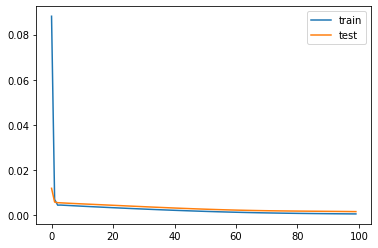

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 534.941


In [ ]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent_7days.csv')

In [ ]:
df7day=pd.read_csv('/content/Predictions_nosent_7days.csv')
df7day.head(5)

,Unnamed: 0,forecast,actual
0,0,37851.661840,38162.764856
1,1,37555.752146,37808.791052
2,2,38024.590467,38069.656152
3,3,37231.079497,37604.305458
4,4,38749.963256,39432.246024


In [ ]:
y=[]
for i in range(len(df7day)):
  x=((abs(df7day['forecast'][i] - df7day['actual'][i] ))  / df7day['actual'][i])*100
  y.append(x)

def Average(lst):
    return sum(lst) / len(lst)

print(Average(y))
Accuracy = 100 - Average(y)
print('The one day Accuracy is {}'.format((Accuracy)))

1.0740387216120826
The one day Accuracy is .98.92596127838792


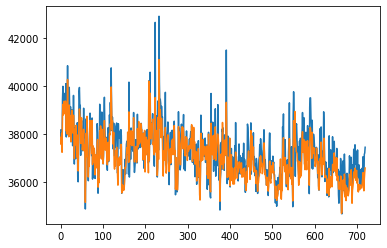

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()